In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import Aut,AutVoll,Baseline,ElAut,ElAutVoll


In [2]:
from matplotlib.colors import ListedColormap
#Create custom color palette for generation technologies
colorsList = ['#DA9A2F','#B1B2B4','#76C26A','#c5abe3','#3B9ED8','#DC5CE5']
techmap = ListedColormap(colorsList)
pv_col = techmap(0)
wind_col = techmap(1)
bm_col = techmap(2)
gt_col = techmap(3)
hydro_col = techmap(4)
imp_col = techmap(5)
cmap_import = ListedColormap([pv_col, bm_col, imp_col])
stomap = ListedColormap([pv_col, bm_col])

In [3]:
scenarios = [Baseline,ElAut,ElAutVoll,Aut,AutVoll]

In [4]:
real_names = {
    "wd": "Weekday",
    "we": "Weekend",
    "ex": "extreme Day",
    "sp": "Spring",
    "su": "Summer",
    "fa": "Fall",
    "wi": "Winter",
    "Baseline": "Baseline",
    "ElAut": "Power Autarky",
    "ElAutVoll": "Power Autarky with VoLL",
    "Aut": "Full Autarky",
    "AutVoll": "Full Autarky with VoLL"    
}

In [5]:
def make_accessible(df,scenario_name):
    df = pd.merge(Aut.ElectricitySurplus[["TS","MY"]], df, on=["MY","TS"], how="left").fillna(0)
    df[['season','day','hour']]=df['TS'].str.split('_',expand=True)
    df["hour"] = df["hour"].astype(int)
    df["day"] = df["day"].apply(lambda x: real_names[x])
    df["season"] = df["season"].apply(lambda x: real_names[x])
    df["scenario"] = scenario_name
    return df

In [6]:
# list of dataframes for later merging
df_list = []
for scenario in scenarios:
    # add techs and calculate total generation
    scenario.YearlyProductionTS["techs"] = scenario.YearlyProductionTS["TC_ds"].str.split("_",expand=True).loc[:,0]
    tot_gen = scenario.YearlyProductionTS.loc[scenario.YearlyProductionTS["EC"]=="el",:].groupby(["MY","techs"]).sum()
    tot_gen = tot_gen.unstack()
    tot_gen.columns = tot_gen.columns.droplevel()
    #tot_gen["Scenario"] = scenario.__name__
    if scenario.__name__ == "Baseline":
        # add import for baseline Scenario
        #scenario.Import.set_index("MY",inplace=True) #FK - this line gave me an error
        tot_gen["Import"] = scenario.Import[scenario.Import["EC"]=="el"]["Val"].values
    
    scenario.tot_gen = tot_gen
    df_list.append(tot_gen)

In [7]:
scenarios[2].tot_gen.div(scenarios[2].tot_gen.sum(axis=1),axis=0)
# possible legend locations
	# best
	# upper right
	# upper left
	# lower left
	# lower right
	# right
	# center left
	# center right
	# lower center
	# upper center
	# center

techs,PV,biomass
MY,,
2021,0.258244,0.741756
2030,0.499510,0.500490
2040,0.517799,0.482201
2050,0.782257,0.217743


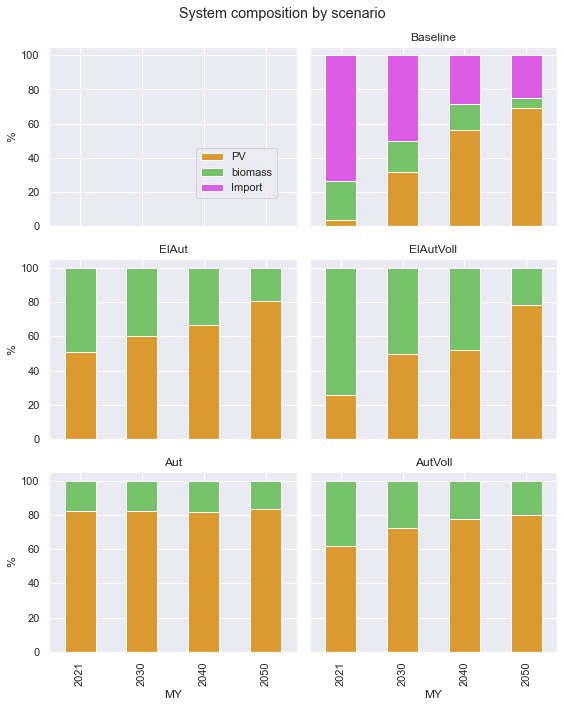

In [8]:
fig, ax = plt.subplots(3,2,figsize=(8,10),sharey=True,sharex=True)
for i,scenario in enumerate(scenarios):
    ix = np.unravel_index(i+1, (3,2))
    # normalize the generation
    normalized = 100*scenario.tot_gen.div(scenario.tot_gen.sum(axis=1),axis=0)
    if len(normalized.columns) == 3:
        cmap = cmap_import
    else:
        cmap = stomap
    normalized.plot(ax=ax[ix], kind="bar",stacked=True, cmap=cmap, legend=False)
    ax[ix].set_title(scenario.__name__)
handles, labels = ax.flat[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="center right",bbox_to_anchor=(0.5, 0.75))#, ncol= 2
# ax[0,1].set_title('Power Autarky')
# ax[0,2].set_title('Power Autarky with VoLL')
# ax[1,0].set_title('Total Autarky')
# ax[1,1].set_title('Total Autarky with VoLL')
ax[0,0].set_ylabel("%")
ax[1,0].set_ylabel("%")
ax[2,0].set_ylabel("%")
plt.suptitle('System composition by scenario')
fig.tight_layout()



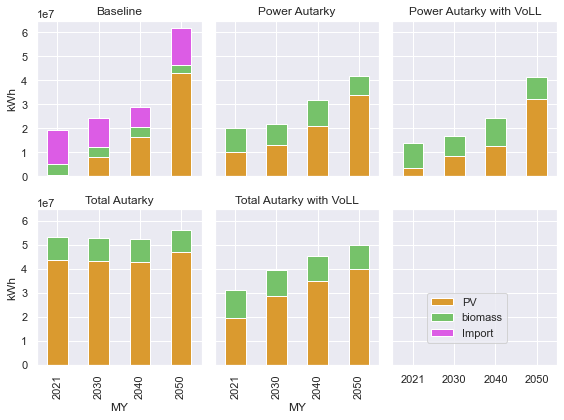

In [9]:
#Total Generation Plot
fig, ax = plt.subplots(2,3,figsize=(8,6),sharey=True,sharex=True)
for i,scenario in enumerate(scenarios):
    ix = np.unravel_index(i, (2,3))
    if len(scenario.tot_gen.columns) == 3:
        cmap = cmap_import
    else:
        cmap = stomap
    scenario.tot_gen.plot(ax=ax[ix], kind="bar",stacked=True, cmap=cmap, legend=False)
    ax[ix].set_title(scenario.__name__)
handles, labels = ax.flat[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center right",bbox_to_anchor=(0.9, 0.25))#, ncol= 2
ax[0,1].set_title('Power Autarky')
ax[0,2].set_title('Power Autarky with VoLL')
ax[1,0].set_title('Total Autarky')
ax[1,1].set_title('Total Autarky with VoLL')
ax[0,0].set_ylabel("kWh")
ax[1,0].set_ylabel("kWh")
fig.tight_layout()


In [10]:
sto_flows = []
for scenario in scenarios:
    # ensure completeness of timestamps
    current_df = make_accessible(scenario.StorageFlows, scenario.__name__)
    sto_flows.append(current_df)
storage_df = pd.concat(sto_flows)
# add the last hour
storage_df.loc[storage_df["hour"]==20,"hour"] = storage_df.loc[storage_df["hour"]==20,"hour"].apply(lambda x: [x, 24])
storage_df = storage_df.explode("hour")
# set to 0, because no info
# storage_df.loc[storage_df["hour"]==24,"Val"] = 0
storage_df

,TS,MY,EC,Val,season,day,hour,scenario
0,sp_wd_1,2021,0,0.000000,Spring,Weekday,1,Baseline
1,sp_wd_6,2021,0,0.000000,Spring,Weekday,6,Baseline
2,sp_wd_8,2021,0,0.000000,Spring,Weekday,8,Baseline
3,sp_wd_10,2021,0,0.000000,Spring,Weekday,10,Baseline
4,sp_wd_12,2021,0,0.000000,Spring,Weekday,12,Baseline
...,...,...,...,...,...,...,...,...
428,wi_ex_14,2050,el,9.753223,Winter,extreme Day,14,AutVoll
429,wi_ex_16,2050,el,-73.692564,Winter,extreme Day,16,AutVoll
430,wi_ex_18,2050,el,-183.696478,Winter,extreme Day,18,AutVoll
431,wi_ex_20,2050,el,-5263.991283,Winter,extreme Day,20,AutVoll


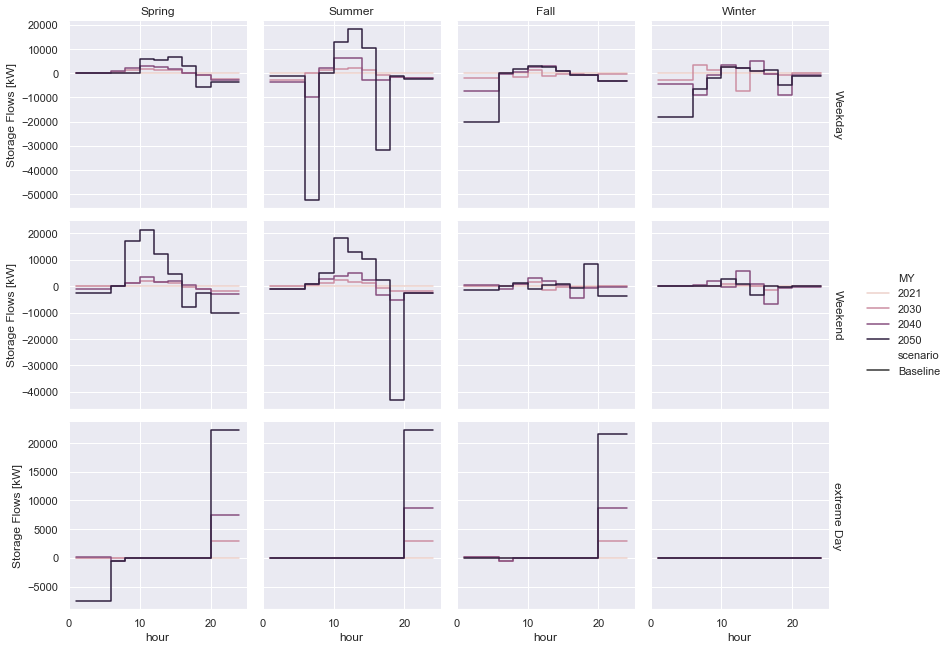

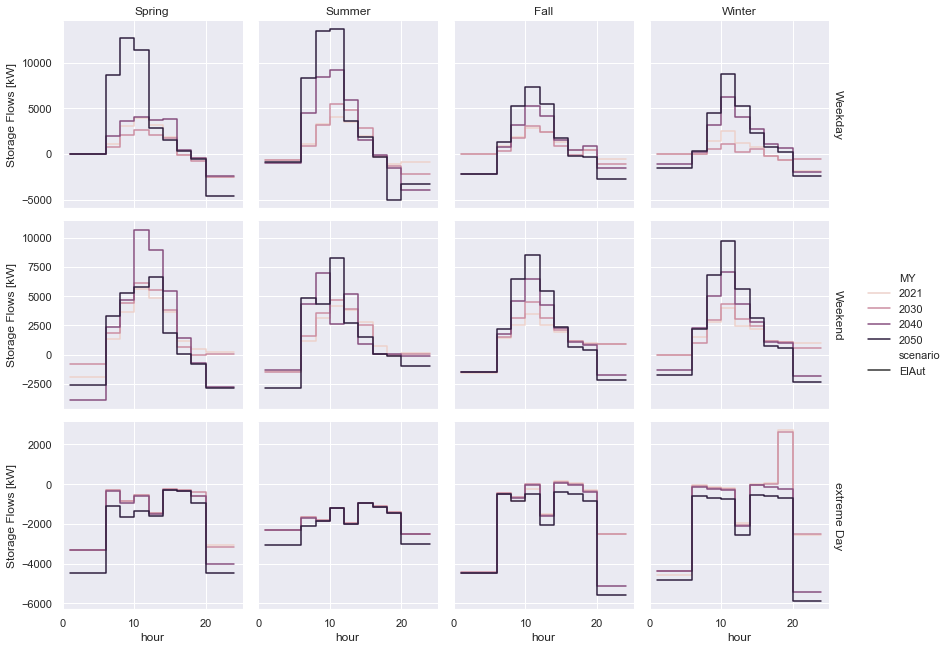

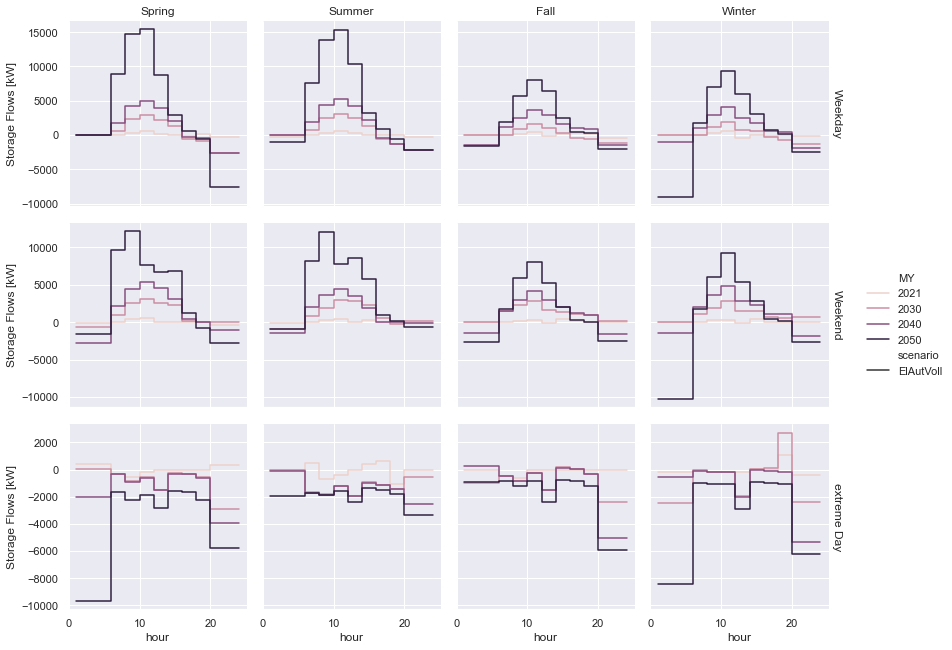

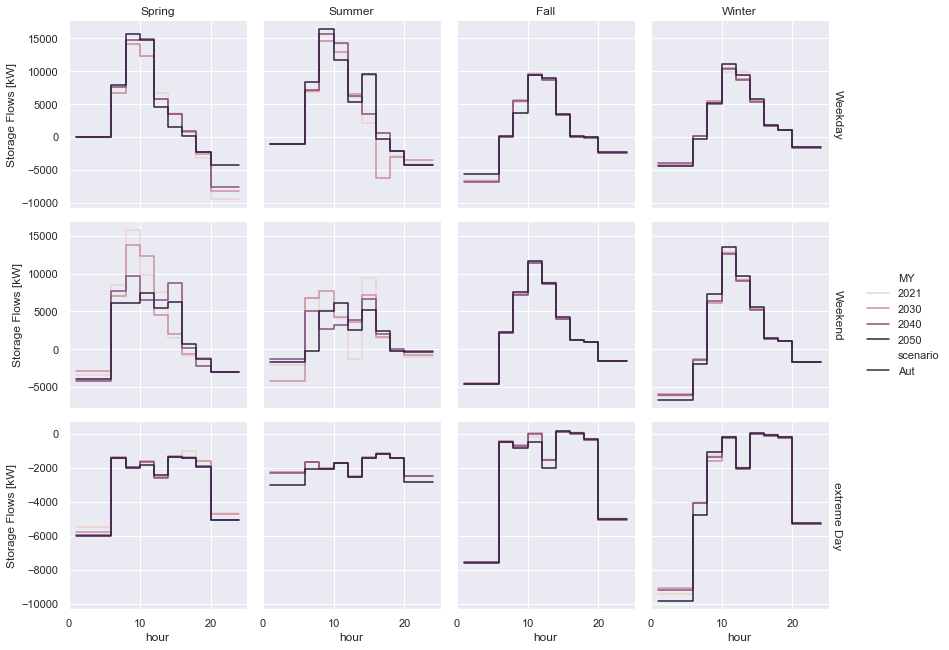

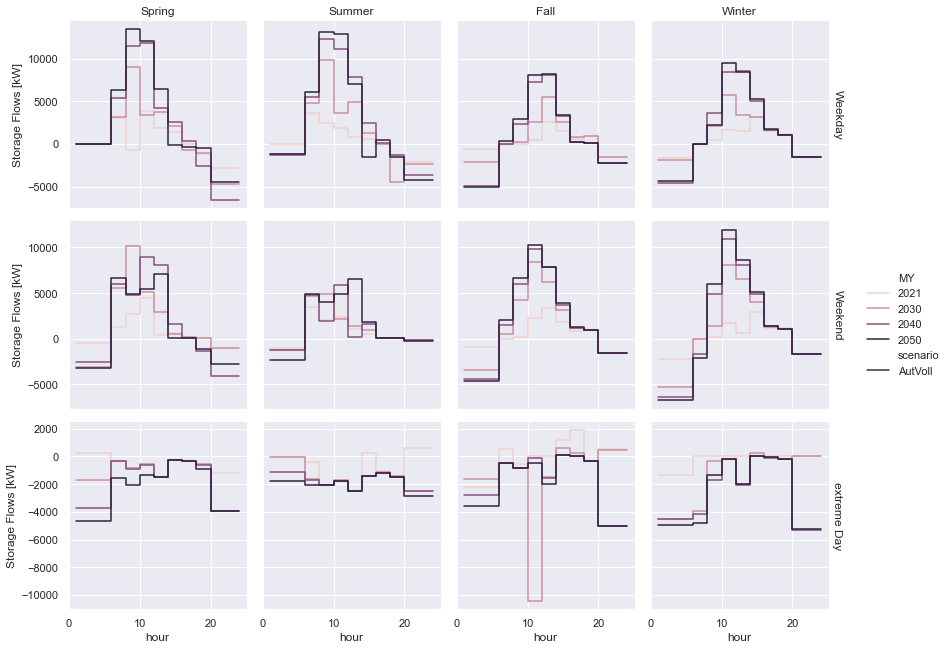

In [11]:
days = storage_df.day.unique()
scenario_names = storage_df.scenario.unique()

# use hour_list for xticks:
hour_list = storage_df["hour"].unique().tolist()
for scenario in scenario_names:
    g = sns.FacetGrid(storage_df.loc[storage_df["scenario"]==scenario,:],#.loc[storage_df["season"]!="Summer",:],
                col="season",row="day",margin_titles=True, sharey="row")
    g.map_dataframe(sns.lineplot,x="hour", y="Val", hue="MY", style="scenario",drawstyle='steps-post')
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.set_axis_labels("hour", "Storage Flows [kW]")
    g.add_legend()
    # g.set(xticks=hour_list, ylim=(-50000,20000))
    #g.savefig(f"plots/storage_flows_all_years_{scenario}.png")

In [12]:
# storage_df.loc[storage_df["day"]==day].describe()["Val"][["min","max"]].tolist()
pair_cmap=sns.color_palette("Paired")
pair_cmap[1:6]

[(0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745)]

In [13]:
bl_col = pair_cmap[3]
ea_col = pair_cmap[1]
eav_col = pair_cmap[9]
ta_col = pair_cmap[7]
tav_col = pair_cmap[5]
allScen_map = [bl_col, ea_col, eav_col, ta_col, tav_col] #It's worse..

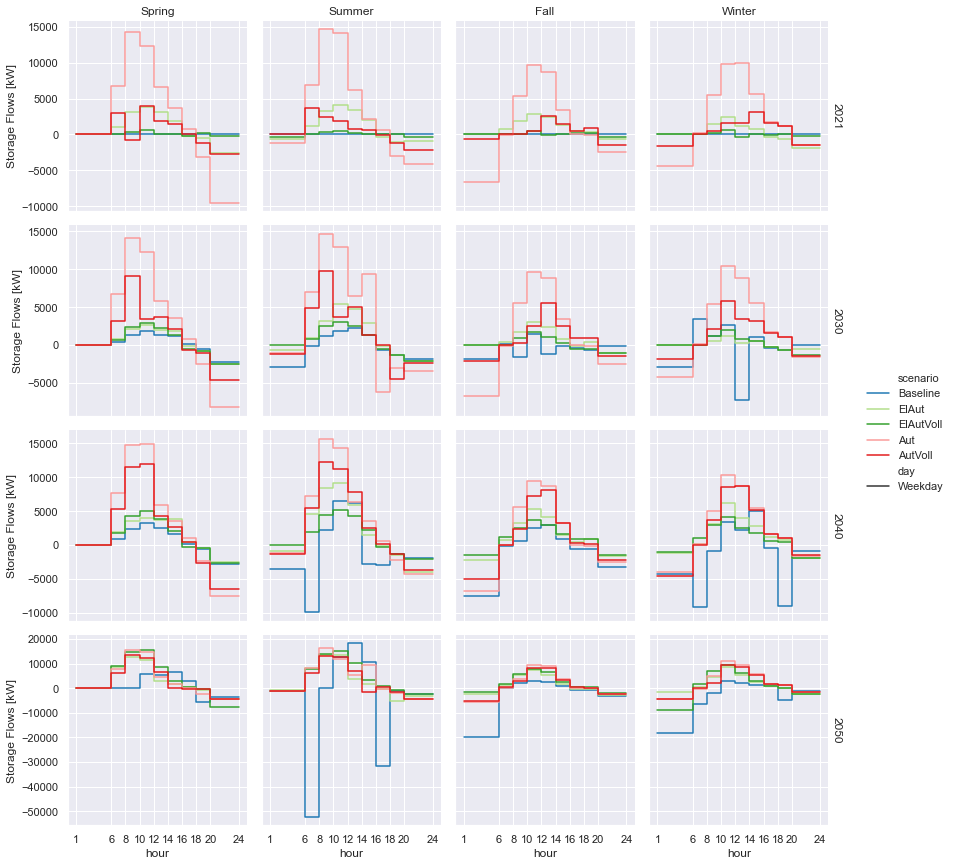

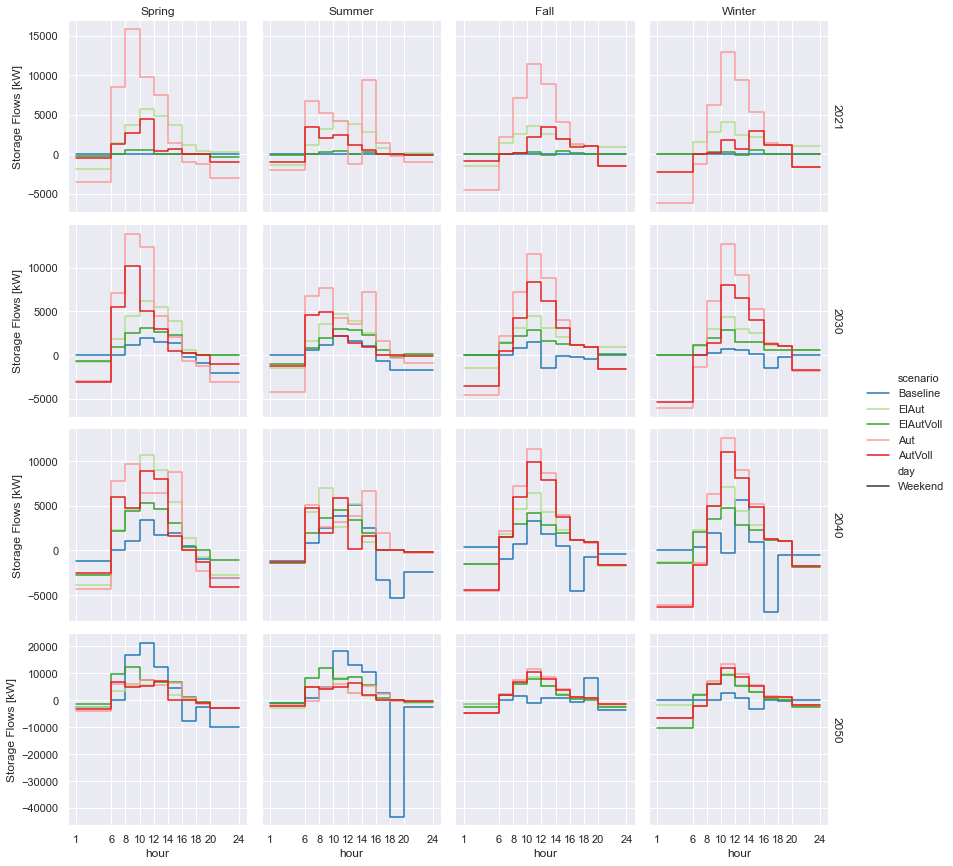

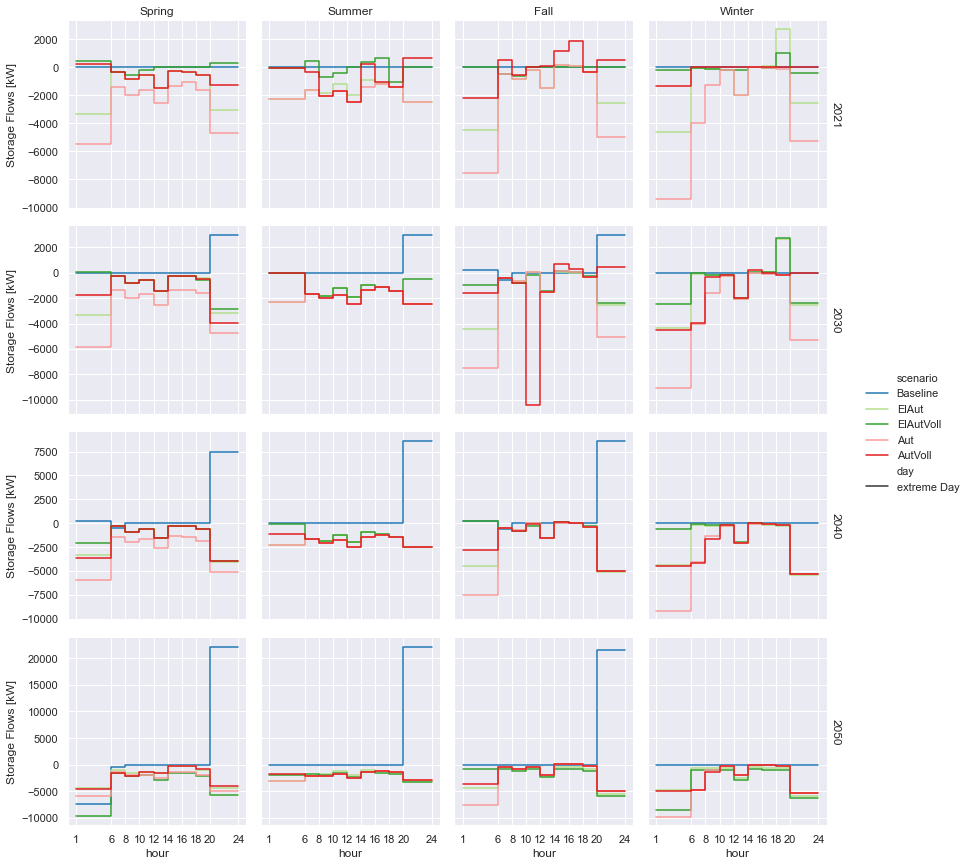

In [14]:
days = storage_df.day.unique()

# use hour_list for xticks:
hour_list = storage_df["hour"].unique().tolist()
for day in days:
    g = sns.FacetGrid(storage_df.loc[storage_df["day"]==day,:],#.loc[storage_df["season"]!="Summer",:],
                col="season",row="MY",margin_titles=True, sharey="row")
    g.map_dataframe(sns.lineplot,x="hour", y="Val", hue="scenario", style="day",drawstyle='steps-post', palette=pair_cmap[1:6])
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.set_axis_labels("hour", "Storage Flows [kW]")
    g.add_legend()
    # lims = storage_df.loc[storage_df["day"]==day].describe()["Val"][["min","max"]].tolist()
    g.set(xticks=hour_list)#, ylim=lims)
#    g.savefig(f"plots/storage_flows_all_years_all_scen_{day}.png")

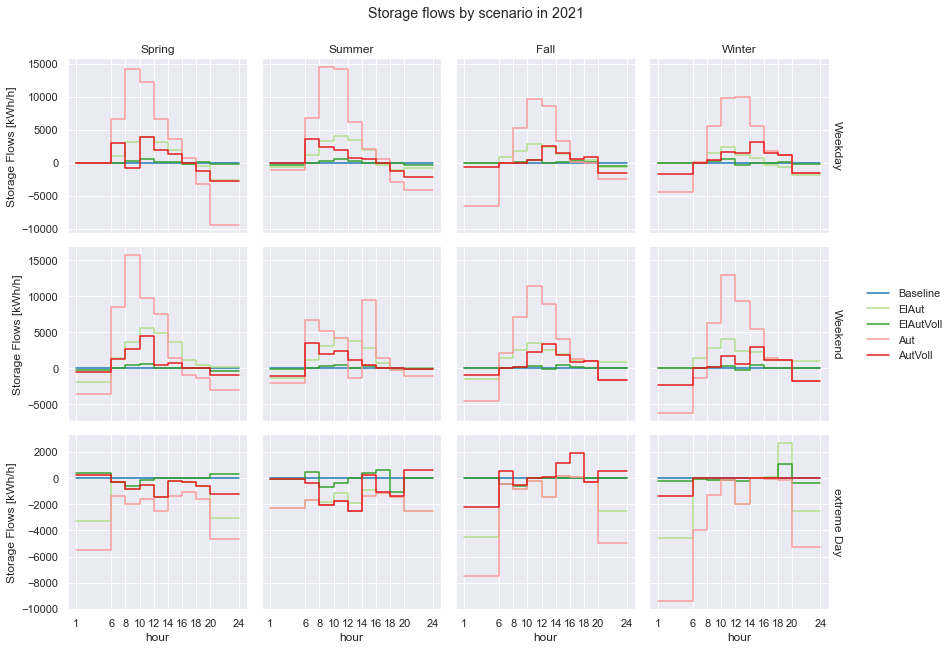

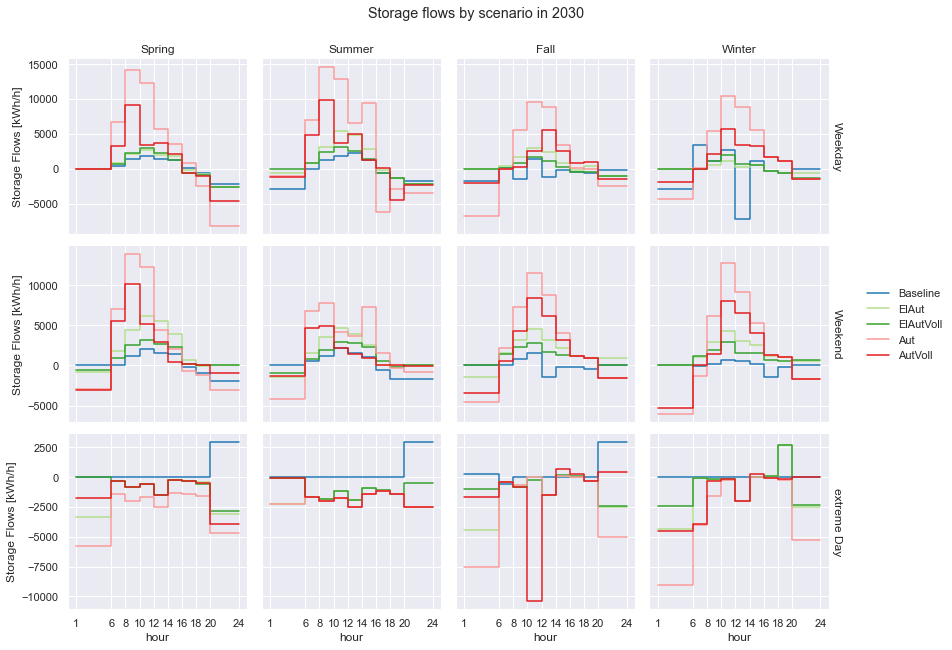

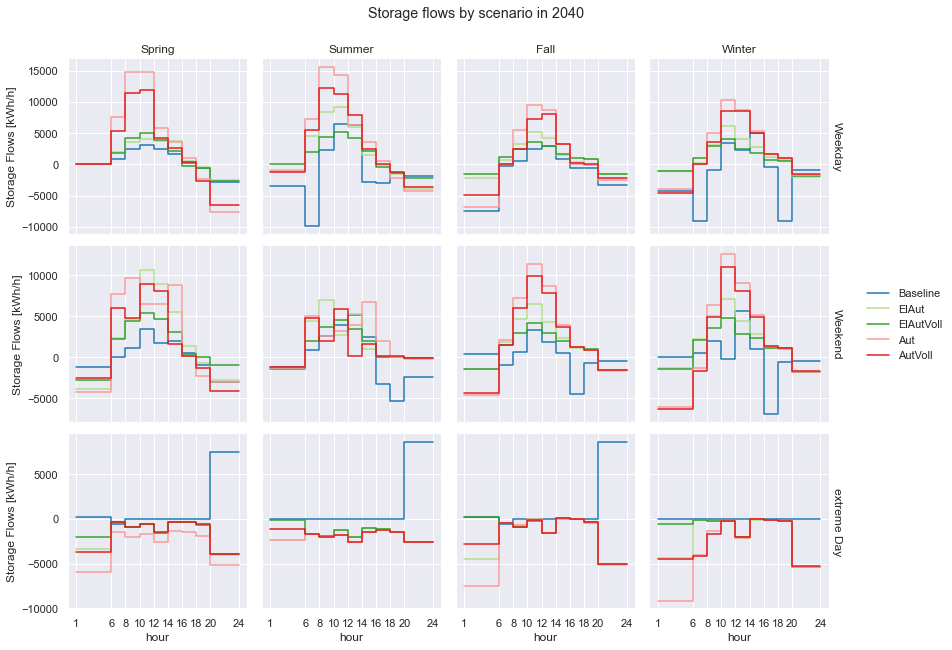

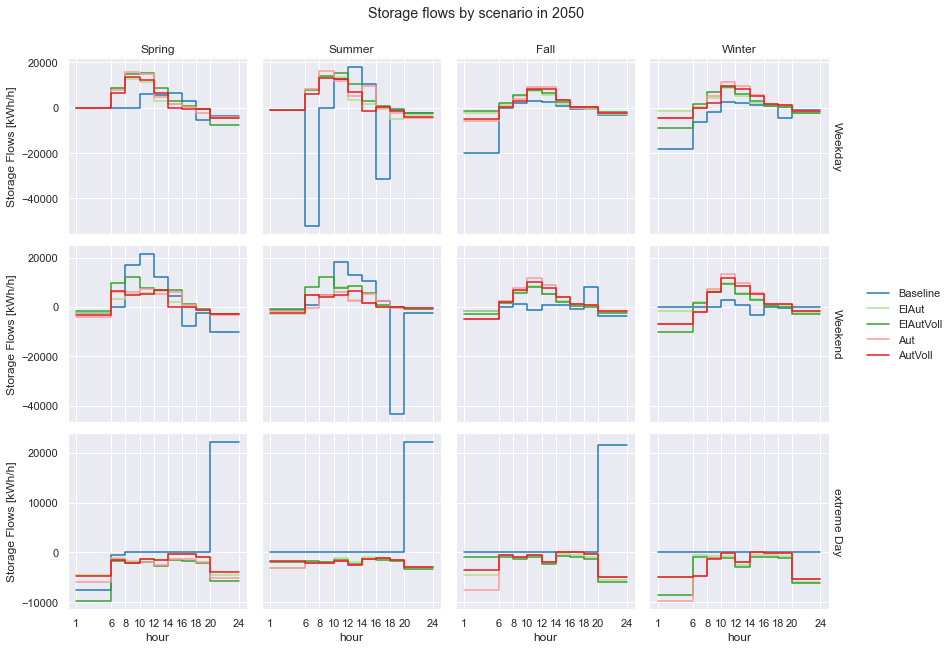

In [15]:
years = storage_df.MY.unique()

# use hour_list for xticks:
hour_list = storage_df["hour"].unique().tolist()
for year in years:
    g = sns.FacetGrid(storage_df.loc[storage_df["MY"]==year,:],#.loc[storage_df["season"]!="Summer",:],
                col="season",row="day",margin_titles=True, sharey="row")
    g.map_dataframe(sns.lineplot,x="hour", y="Val", hue="scenario",drawstyle='steps-post', palette=pair_cmap[1:6])
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.set_axis_labels("hour", "Storage Flows [kWh/h]")
    g.add_legend()
    # g.set(xticks=hour_list, ylim=(-50000,20000))
    g.set(xticks=hour_list)
    g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
    g.fig.suptitle(f'Storage flows by scenario in {year}')
    g.savefig(f"plots/storage_flows_all_{year}.png")

In [16]:
# construct an actual timestamp
seasons = storage_df.season.unique()
months = [3,6,9,12]
season_map = dict(zip(seasons,months))
# first businessdays in month
date_list = []
for year in storage_df.MY.unique():
    date_range = pd.date_range(f'1/1/{year}', f'12/1/{year}', freq='MS')
    date_list.append(pd.Series(date_range))
possible_dates = pd.concat(date_list)

# keep only months listed above
relevant = possible_dates.apply(lambda x: x.month in months)
weekdays = possible_dates[relevant]
time_df = pd.DataFrame(dict(date=weekdays)).reset_index(drop=True)
time_df["day_of_week"] = time_df.date.apply(lambda x: x.day_name())
time_df["day_of_week_num"] = time_df.date.apply(lambda x: x.dayofweek)

# get  next friday
def next_friday(date):
    # friday is 4
    days_till_friday = 4 -date.dayofweek
    if days_till_friday < 0:
        days_till_friday += 7
    return date + pd.Timedelta(days_till_friday, unit="day")
time_df["weekday"] = time_df.date.apply(next_friday)
time_df["weekend"] = time_df["weekday"] + pd.Timedelta(1,unit="day")
time_df["extreme_day"] = time_df["weekend"] + pd.Timedelta(1,unit="day")
time_df

,date,day_of_week,day_of_week_num,weekday,weekend,extreme_day
0,2021-03-01,Monday,0,2021-03-05,2021-03-06,2021-03-07
1,2021-06-01,Tuesday,1,2021-06-04,2021-06-05,2021-06-06
2,2021-09-01,Wednesday,2,2021-09-03,2021-09-04,2021-09-05
3,2021-12-01,Wednesday,2,2021-12-03,2021-12-04,2021-12-05
4,2030-03-01,Friday,4,2030-03-01,2030-03-02,2030-03-03
5,2030-06-01,Saturday,5,2030-06-07,2030-06-08,2030-06-09
6,2030-09-01,Sunday,6,2030-09-06,2030-09-07,2030-09-08
7,2030-12-01,Sunday,6,2030-12-06,2030-12-07,2030-12-08
8,2040-03-01,Thursday,3,2040-03-02,2040-03-03,2040-03-04
9,2040-06-01,Friday,4,2040-06-01,2040-06-02,2040-06-03


In [17]:
# wide to long converision
dates_df = pd.melt(time_df,id_vars=["day_of_week"],value_vars=["weekday","weekend","extreme_day"])

dates_df.rename(columns={"variable":"day_type"},inplace=True)
# overwrite old dow with actual day of week
dates_df["day_of_week"] = dates_df["value"].apply(lambda x: x.day_name())

# add hours as list to each row
dates_df["hour"] = [[ 1,  6,  8, 10, 12, 14, 16, 18, 20]]*len(dates_df)

# "explode" to generate desired hour column
dates_df = dates_df.explode("hour")
season_map_T = dict(zip(months,seasons))
dates_df["season"] = dates_df.value.apply(lambda x: season_map_T[x.month])

# dates_df["value"] = dates_df["value"].apply + pd.Timedelta(dates_df["hour"],unit="h")
dates_df["hour"] = dates_df["hour"].apply(lambda x: pd.Timedelta(x, unit="h"))
dates_df["t"] = dates_df["value"] +dates_df["hour"]
dates_df

,day_of_week,day_type,value,hour,season,t
0,Friday,weekday,2021-03-05,0 days 01:00:00,Spring,2021-03-05 01:00:00
0,Friday,weekday,2021-03-05,0 days 06:00:00,Spring,2021-03-05 06:00:00
0,Friday,weekday,2021-03-05,0 days 08:00:00,Spring,2021-03-05 08:00:00
0,Friday,weekday,2021-03-05,0 days 10:00:00,Spring,2021-03-05 10:00:00
0,Friday,weekday,2021-03-05,0 days 12:00:00,Spring,2021-03-05 12:00:00
...,...,...,...,...,...,...
47,Sunday,extreme_day,2050-12-04,0 days 12:00:00,Winter,2050-12-04 12:00:00
47,Sunday,extreme_day,2050-12-04,0 days 14:00:00,Winter,2050-12-04 14:00:00
47,Sunday,extreme_day,2050-12-04,0 days 16:00:00,Winter,2050-12-04 16:00:00
47,Sunday,extreme_day,2050-12-04,0 days 18:00:00,Winter,2050-12-04 18:00:00


In [19]:
imports_df = make_accessible(Baseline.ImportFlows, "Imports (Baseline)")
imports_df = imports_df.loc[imports_df["EC"]=="el",:]


In [20]:

full_aut_voll_df = make_accessible(AutVoll.VollLostLoadFlows,"Lost Load (AutVoll)")
elec_aut_voll_df = make_accessible(ElAutVoll.VollLostLoadFlows, "Lost Load (ElAutVoll)")
test_df = pd.concat([imports_df, elec_aut_voll_df, full_aut_voll_df]).fillna(0).reset_index(drop=True).drop("EC",axis=1)
test_df.loc[test_df["hour"]==20,"hour"] = test_df.loc[test_df["hour"]==20,"hour"].apply(lambda x: [x, 24])
test_df = test_df.explode("hour")
test_df

,TS,MY,Val,season,day,hour,scenario
0,sp_wd_1,2021,2526.893310,Spring,Weekday,1,Imports (Baseline)
1,sp_wd_6,2021,398.028407,Spring,Weekday,6,Imports (Baseline)
2,sp_wd_8,2021,457.015873,Spring,Weekday,8,Imports (Baseline)
3,sp_wd_10,2021,409.151125,Spring,Weekday,10,Imports (Baseline)
4,sp_wd_12,2021,743.642243,Spring,Weekday,12,Imports (Baseline)
...,...,...,...,...,...,...,...
1149,wi_ex_14,2050,0.000000,Winter,extreme Day,14,Lost Load (AutVoll)
1150,wi_ex_16,2050,0.000000,Winter,extreme Day,16,Lost Load (AutVoll)
1151,wi_ex_18,2050,0.000000,Winter,extreme Day,18,Lost Load (AutVoll)
1152,wi_ex_20,2050,0.000000,Winter,extreme Day,20,Lost Load (AutVoll)


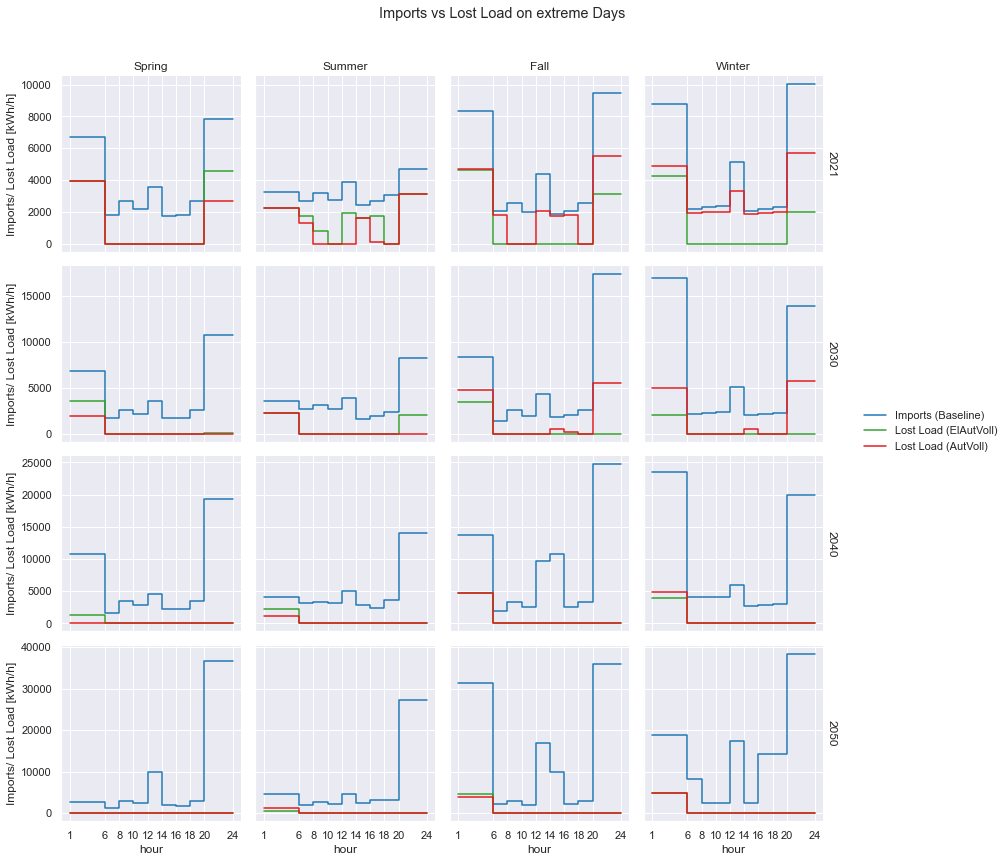

In [21]:

g = sns.FacetGrid(test_df.loc[test_df["day"]=="extreme Day",:],
            col="season",row="MY",margin_titles=True, sharey="row")
g.map_dataframe(sns.lineplot,x="hour", y="Val", hue="scenario", drawstyle='steps-post', palette=[pair_cmap[1],pair_cmap[3],pair_cmap[5]])
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_axis_labels("hour", "Imports/ Lost Load [kWh/h]")
g.add_legend()
g.fig.subplots_adjust(top=0.92)
#g.fig.suptitle("Imports vs Lost Load on extreme Days")
g.set(xticks=hour_list)
g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle(f'Imports vs Lost Load on extreme Days')
g.savefig("plots/storage_vs_VoLL_flows.png")

In [ ]:
e_aut_Voll = make_accessible(El_aut_voll.VollLostLoadFlows,"ElAut_VoLLFlow")
e_aut_batt = make_accessible(El_aut_voll.StorageFlows, "ElAut_StorageFlow")
voll_batt_df = pd.concat([e_aut_Voll,e_aut_batt]).reset_index(drop=True).drop("EC",axis=1)
voll_batt_df 

In [ ]:
g = sns.FacetGrid(e_aut_Voll,#.loc[test_df["MY"]==2021,:],
            col="season",row="day",margin_titles=True)
g.map_dataframe(sns.lineplot,x="hour", y="Val", hue="scenario", style="MY")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_axis_labels("hour", "Storage Flows [MW???]")
g.add_legend()

In [ ]:
import seaborn as sns
sns.set_theme(style="ticks")

dots = sns.load_dataset("dots")

# Define the palette as a list to specify exact values
palette = sns.color_palette("rocket_r")

# Plot the lines on two facets
sns.relplot(
    data=dots,
    x="time", y="firing_rate",
    hue="coherence", size="choice", col="align",
    kind="line", size_order=["T1", "T2"], palette=palette,
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)

In [ ]:
dots

In [ ]:
#Sensitivity analysis where the VoLL rate was changed, applied to the total autarky scenario

sensitivity = pd.read_csv('sensitivity.csv',index_col='Unnamed: 0').rename(index={'Baseline':'100'})
ref = 2.723547e+08 #Cost of Baseline scenario (cost['TotalCost'])
sensitivity.head()

In [ ]:
#Chepaer VoLL means that it is used omre but the share of the total costs due to it reduces as it is cheaper to use 
# + At most, 0.3% of the load is not served

fig, ax = plt.subplots(figsize=(9,5))
#plt.title('Cost reductions and increases in Lost Load due to reduction of VoLL price')
ax.plot((100*sensitivity[['total cost (Eur)']]/ref - 100),color='red')
ax.set_ylabel("Deviation from Baseline system cost (%)",color="red")
ax.set_xlabel('VoLL price (% of original)')
ax2=ax.twinx()
ax2.plot((100*sensitivity['lost load (kWh)']/(sensitivity['load (kWh)']+sensitivity['lost load (kWh)'])),color='black')
ax2.set_ylabel("Share of total load that is shed (%)")
ax.grid(False)
ax2.grid(False)
# fig.savefig("plots/Sensitivity.png")

In [ ]:
from matplotlib import ticker

sensitivity = pd.read_csv('sensitivity.csv',index_col='Unnamed: 0').rename(index={'Baseline':'100'})
ref = 2.723547e+08 #Cost of Baseline scenario (cost['TotalCost'])
sensitivity.head()
cost_deviation = 100*sensitivity[['total cost (Eur)']]/ref - 100
shed_load = 100*sensitivity['lost load (kWh)']/(sensitivity['load (kWh)'])
fig, ax = plt.subplots(figsize=(9,5))
#plt.title('Cost reductions and increases in Lost Load due to reduction of VoLL price')


ax.plot(cost_deviation,color='darkblue')
ax.set_ylabel("Cost increase from Baseline system (%)",color="darkblue")
ax.set_xlabel('VoLL price (% of original)')
ax2=ax.twinx()
ax2.plot(shed_load,color='black')
ax2.set_ylabel("Share of total load that is shed (%)")
ax.set_ylim(35,65)
ax2.set_ylim(0.2,1.7)
l = ax.get_ylim()
l2 = ax2.get_ylim()
f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
ticks = f(ax.get_yticks())
ax2.yaxis.set_major_locator(ticker.FixedLocator(ticks))
ax.tick_params(axis="y", color="darkblue", labelcolor="darkblue")
ax.set_yticklabels(['+35','+40','+45','+50','+55','+60','+65'])
ax2.grid(False)
#ax.axhline(y=36, color='r', linestyle='-', label='ElAut')
plt.title('Sensitivity analysis on VoLL under AutVoll')
fig.savefig("plots/Sensitivity_DH.png")

In [ ]:
ax.get_yticklabels()

In [ ]:
ax2.get_ylim()